# Code:  DATA Analysis
## Importing important packages

In [1]:
from collections import OrderedDict
from io import StringIO
import pandas as pd
import numpy as np
import prince
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import rpy2

## Functions
### Read gct file to data frame

In [2]:
def gct_format_to_df(file_path):
## Importing important packagesct_format_to_df(file_path):
    """This function is used to read the gct file and convert it into dataframe"""
    raw_intensity_df = pd.DataFrame()
    metadata_df = pd.DataFrame()
    dimensions_dict = {}
    read_gct = open(file_path,'r').read().splitlines()
    gct_format_info = list(map(lambda element: element.split('\t'), read_gct[:2])) # separate strings based on '\t'
    gct_format_info = list(map(lambda element: list(filter(None,element)),gct_format_info))
    raw_intensity_data = '\n'.join(read_gct[2:])
    version = gct_format_info[0][0] # Version
    if str(version) != '#1.3':
        return 'This function only supports version #1.3. please check the gct format'
    dimensions = gct_format_info[1] # Dimensions
    dimensions = list(map(lambda x:int(float(x)), dimensions)) # convert string to int        
    dimensions_dict = {'rids':dimensions[0],'cids':dimensions[1],'rhds':dimensions[2],'chds':dimensions[3]}
    # Read Raw intensity data
    TESTDATA = StringIO(raw_intensity_data)
    gct_df = pd.read_csv(TESTDATA,sep='\t')
    raw_intensity_df = gct_df.iloc[dimensions_dict['chds']:].reset_index(drop=True)
    # Read metadata
    metadata_df = gct_df.iloc[:dimensions_dict['chds']].T
    metadata_df.columns = metadata_df.iloc[0]
    metadata_df = metadata_df.iloc[(dimensions_dict['rhds']+1):]
    metadata_df = metadata_df.reset_index()
    metadata_df = metadata_df.rename(columns={'index':'SampleName'})
    return [raw_intensity_df, metadata_df]

### Convert raw intensity dataframe to gct format using metadata information

In [3]:
def df_to_gct_format(raw_intensity_df,meta_sample_df,save_path):
    """This function is used to convert raw intensity dataframe to gct format using metadata information"""
    raw_intensity_df_cp = raw_intensity_df.copy()
    meta_sample_df_cp = meta_sample_df.copy()
    raw_samples_list =  raw_intensity_df_cp.columns.tolist()
    metadata_samples_list = meta_sample_df_cp[meta_sample_df_cp.columns[0]].tolist()
    samples_list = sorted(set(metadata_samples_list) & set(raw_samples_list), key = raw_samples_list.index)
    rhds_list = raw_intensity_df_cp.drop(samples_list,axis=1).columns.tolist()
    metab_counts = len(raw_intensity_df_cp[rhds_list[0]])
    meta_sample_df_cp.set_index(meta_sample_df_cp.columns[0],inplace=True)
    metadata_cols_list = meta_sample_df_cp.columns
    metadata_cols_len = len(metadata_cols_list)
    for chds_index in range(metadata_cols_len):
        metadata_col = metadata_cols_list[chds_index]
        chds_sample_map_list = meta_sample_df_cp.loc[samples_list][metadata_col].values.tolist()
        chds_row_list = [metadata_col] + ['na']*(len(rhds_list)-1)
        chds_row_list.extend(chds_sample_map_list)
        raw_intensity_df_cp.loc[(chds_index-metadata_cols_len)] = chds_row_list
    raw_intensity_df_cp.index = raw_intensity_df_cp.index + metadata_cols_len
    raw_intensity_df_cp = raw_intensity_df_cp.sort_index()
    raw_intensity_str = StringIO()
    raw_intensity_df_cp.to_csv(raw_intensity_str,sep='\t',index=False)
    dimensions = '\t'.join([str(metab_counts),str(len(samples_list)),str(len(rhds_list)-1),str(metadata_cols_len)])
    version = '#1.3'
    gct_format_str = '\n'.join([version,dimensions,raw_intensity_str.getvalue()])
    with open(save_path, "w") as text_file:
        text_file.write(gct_format_str)

### Make unique ids for the metabolites

In [4]:
def make_unique_id_raw_df(maven_output, mode):
    """This function will make unique ids for the metabolites using the medRt, medMz and mode information."""
    maven_output_updated = maven_output.copy()
    isotopelabel_list = maven_output_updated['isotopeLabel'].tolist()
    unique_id_list = []
    if 'C12 PARENT' in isotopelabel_list:
        for index, row in maven_output_updated.iterrows():
            cmpd_id = row['compoundId']
            isotopelabel = row['isotopeLabel']
            if isotopelabel == 'C12 PARENT':
                metaGroupId = row['metaGroupId']
                medRT = round(row['medRt'],3)
                medMZ = round(row['medMz'],3)
            unique_id = '_'.join([str(metaGroupId),str(cmpd_id),str(medMZ),str(medRT),str(mode)])
            unique_id_list.append(unique_id)
    else:
        for index, row in maven_output_updated.iterrows():
            metaGroupId = row['metaGroupId']
            cmpd_id = row['compoundId']
            medRT = round(row['medRt'],3)
            medMZ = round(row['medMz'],3)
            unique_id = '_'.join([str(metaGroupId),str(cmpd_id),str(medMZ),str(medRT),mode])
            unique_id_list.append(unique_id)

    maven_output_updated['uniqueId'] = unique_id_list
    return maven_output_updated

### Filter columns

In [5]:
def filter_samples_cols_df(raw_intensity_df):
    """This function can be used to filter columns."""
    remove_cols_list = ['label', 'metaGroupId', 'groupId', 'goodPeakCount', 
                        'maxQuality', 'formula', 'expectedRtDiff','ppmDiff', 'parent']
    raw_intensity_filtered_cols_df = raw_intensity_df.drop(remove_cols_list,axis=1)
    return raw_intensity_filtered_cols_df

### Calculate pooltotal

In [6]:
def calculate_pooltotal_df(raw_intensity_unique_id_df):
    """This function can be used to calculate pooltotals."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    if cmpd_identifiers_list[0] not in raw_intensity_unique_id_df.columns:
        return "Please do the preprocessing of the maven output"
    compound_samples_raw_intensity_df = filter_samples_cols_df(raw_intensity_unique_id_df)
    raw_intensity_filtered_df = compound_samples_raw_intensity_df.drop(cmpd_identifiers_list[3:],axis=1)
    pooltotal_df = raw_intensity_filtered_df.groupby(cmpd_identifiers_list[:3],sort=False).sum(numeric_only=True).reset_index()
    pooltotal_df_object= pooltotal_df[cmpd_identifiers_list[0]].str.split('_').str
    pooltotal_df[cmpd_identifiers_list[3]] = pooltotal_df_object[2]
    pooltotal_df[cmpd_identifiers_list[4]] = pooltotal_df_object[3]
    samples_list = pooltotal_df.drop(cmpd_identifiers_list[:5], axis=1).columns.tolist()
    columns_order_list = cmpd_identifiers_list[:5] + samples_list
    pooltotal_df = pooltotal_df.reindex(columns=columns_order_list)
    return pooltotal_df

### Information of mean and std for each cohot

In [7]:
def create_cohortwise_compound_df(processed_df, metadata_sample_df, cohort_col='Cohort'):
    """This function will make new dataframe having information of mean and std for each cohort"""
    cohort_compound_df = pd.DataFrame()
    cohort_list = metadata_sample_df[cohort_col].unique().tolist()
    samples_list = metadata_sample_df[metadata_sample_df.columns[0]].tolist()
    id_cols_list = processed_df.columns[~processed_df.columns.isin(samples_list)].tolist()
    all_cols_list = id_cols_list + ['cohort', 'cv', 'mean', 'std']
    for index, row in processed_df.iterrows():
        id_cols_values = row[id_cols_list]
        for cohort in cohort_list:
            cv = np.nan
            cohort_samples = metadata_sample_df[metadata_sample_df[cohort_col]==cohort][metadata_sample_df.columns[0]]
            cohort_samples_values = row[cohort_samples].astype(float)
            mean = np.mean(cohort_samples_values.values)
            std = np.std(cohort_samples_values.values)
            if mean>0:
                cv = (std/mean)*100
            all_values = id_cols_values.tolist() + [cohort, cv, mean, std]
            interm_cols_dict = OrderedDict(zip(all_cols_list, all_values))
            interm_df = pd.DataFrame(interm_cols_dict, index=[0])
            cohort_compound_df = pd.concat([cohort_compound_df,interm_df],ignore_index=True)
    return cohort_compound_df

In [8]:
def create_cohortwise_boxplot(processed_df):
    variance_list = ['cv', 'mean', 'std']
    cohort_list = processed_df['cohort'].unique().tolist()
    data = []
    for cohort in cohort_list:
        cohortwise_metab_df = processed_df[processed_df['cohort'] == cohort]
        trace1 = go.Box(
            y = cohortwise_metab_df['cv'],
            text = cohortwise_metab_df[cohortwise_metab_df.columns[0]],
            name=cohort, boxpoints = 'all', jitter=0.3, pointpos=-1.8, boxmean='sd',
        )
        data.append(trace1)
    layout = go.Layout(title='CV Distribution across Cohorts',    
                       xaxis=dict(title='Cohorts', titlefont=dict(size=14)),
                       yaxis=dict(title='Coefficient of Variation (%)',
                                  titlefont=dict(size=14), range = [0,100])
                      )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='box_plot')

### Combine mode, unique-id to compound. Output to IsoCorrect

In [9]:
def combine_cmpd_id_mode_df(maven_output):
    """This function will combine mode, unique-id to compound. The output will be the input of IsoCorrect."""
    combine_cmpd_id_mode_nacorr_df = maven_output.copy()
    def join_str(row):
        compound = row['compound'].split('|')[0].strip()
        unique_id = row['uniqueId']
        return "_".join([compound,unique_id])
    combine_cmpd_id_mode_nacorr_df['compound'] = combine_cmpd_id_mode_nacorr_df.apply(lambda row: join_str(row), axis=1)
    combine_cmpd_id_mode_nacorr_df.drop(['uniqueId'],axis=1,inplace=True)
    return combine_cmpd_id_mode_nacorr_df

### Convert long format to wide format

In [10]:
def make_cmpd_samples_wide_format_df(na_corrected_df):
    """This function can be used to convert long format to wide format with specific columns."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    pivot_na_corr_df = pd.DataFrame(pd.pivot_table(na_corrected_df, 
                                                   values='Fractional Enrichment with zero', 
                                                   index=['Name','Label'], columns='Sample', aggfunc=np.mean).reset_index())
    pivot_na_corr_df['compound'], pivot_na_corr_df['uniqueId'] = pivot_na_corr_df['Name'].str.split('_',1).str
    cmpd_id_df_object= pivot_na_corr_df['uniqueId'].str.split('_').str
    pivot_na_corr_df['compoundId'] = cmpd_id_df_object[0]
    pivot_na_corr_df['medMz'] = cmpd_id_df_object[1]
    pivot_na_corr_df['medRt'] = cmpd_id_df_object[2]
    pivot_na_corr_df.rename(columns = {'Label':'isotopeLabel'},inplace=True)
    pivot_na_corr_df.drop(['Name'],axis=1,inplace=True)
    samples_list = pivot_na_corr_df.drop(cmpd_identifiers_list, axis=1).columns.tolist()
    columns_order = cmpd_identifiers_list + samples_list
    pivot_na_corr_df = pivot_na_corr_df.reindex(columns=columns_order)
    return pivot_na_corr_df

### Calculate total labels

In [11]:
def calculate_total_labels_df(na_corr_raw_df):
    """This function can be used to calculate total labels."""
    cmpd_identifiers_list = ['uniqueId','compound', 'compoundId', 'medMz', 'medRt', 'isotopeLabel']
    na_corr_wide_df = make_cmpd_samples_wide_format_df(na_corr_raw_df)
    filter_labels_na_corr_df = na_corr_wide_df[~(na_corr_wide_df[cmpd_identifiers_list[5]] == 'C12 PARENT')]
    total_labels_df = filter_labels_na_corr_df.groupby(cmpd_identifiers_list[:3],sort=False).sum(numeric_only=True).reset_index()
    total_labels_df_object= total_labels_df[cmpd_identifiers_list[0]].str.split('_').str
    total_labels_df[cmpd_identifiers_list[3]] = total_labels_df_object[2]
    total_labels_df[cmpd_identifiers_list[4]] = total_labels_df_object[3]
    samples_list = total_labels_df.drop(cmpd_identifiers_list[:5], axis=1).columns.tolist()
    columns_order_list = cmpd_identifiers_list[:5] + samples_list
    total_labels_df = total_labels_df.reindex(columns=columns_order_list)
    mean_metab_series = total_labels_df.drop(cmpd_identifiers_list[:5],axis=1).mean(axis=1,numeric_only=True)
    filter_bool = mean_metab_series >= 0.01
    total_labels_df = total_labels_df[filter_bool]
    return total_labels_df

### Remove duplicate metabolites by pval

In [12]:
def filter_unique_cmpd_combiT(diff_exp_df):
    """This function can be used to remove duplicate metabolites by pval."""
    filtered_stat_anal_df = pd.DataFrame()
    compounds = diff_exp_df['compoundId'].unique()
    for cmpd in compounds:
        short_cmpd_df = diff_exp_df[diff_exp_df['compoundId']==cmpd]
        low_pval_df =short_cmpd_df[short_cmpd_df['P.Value'] == short_cmpd_df['P.Value'].min()]
        filtered_stat_anal_df = pd.concat([filtered_stat_anal_df,low_pval_df],ignore_index=True)
    filtered_stat_anal_df = filtered_stat_anal_df[['id', 'compoundId','logFC','P.Value']]
    filtered_stat_anal_df = filtered_stat_anal_df[filtered_stat_anal_df['P.Value'] != 'NaN']
    filtered_stat_anal_df = filtered_stat_anal_df.rename(columns={"compoundId":'ID', 'id':'uniqueId'})
    filtered_stat_anal_df = filtered_stat_anal_df.set_index('uniqueId')
    return filtered_stat_anal_df

## Read maven output and metadata

In [13]:
mode = 'neg'
maven_output_path = "Labeled_LCMS_group_summary_format_maven_output.csv"
maven_output_df = pd.read_csv(maven_output_path)

metadata_path = "LCMS_labeled_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

In [14]:
maven_output_df.head()

label  metaGroupId  groupId  goodPeakCount      medMz  medRt  maxQuality  \
0    NaN            1        1             16  87.008743  8.588    0.803911   
1    NaN            1        2             12  88.012100  8.576    0.822778   
2    NaN            1        3              6  89.015450  8.594    0.826114   
3    NaN            1        4             13  90.018806  8.588    0.827043   
4    NaN            2        5             16  87.008743  8.588    0.803911   

  isotopeLabel         compound compoundId  ... 091215_15M  091215_15i  \
0   C12 PARENT         Pyruvate     C00022  ...  849143.50   550175.31   
1  C13-label-1         Pyruvate     C00022  ...   10032.35      587.01   
2  C13-label-2         Pyruvate     C00022  ...    2549.27     2508.14   
3  C13-label-3         Pyruvate     C00022  ...  235960.94   339493.16   
4   C12 PARENT  3-Oxopropanoate     C00222  ...  849143.50   550175.31   

   091215_5M  091215_5i  091215_3M  091215_3i  091215_1M  091215_1i  \
0  853230.94  521816.94  861357.56  342561.94  993114.94  582680.38   
1   10755.05    4774.59   13109.85    4598.37    8617.67    5070.62   
2       0.00       0.00       0.00       0.00       0.00       0.00   
3   72895.64  160703.12   56355.04   67502.30    9430.08   13710.24   
4  853230.94  521816.94  861357.56  342561.94  993114.94  582680.38   

    091215_0M   091215_0i  
0  1653916.88  1965592.25  
1    27084.07    31817.76  
2        0.00      365.30  
3        0.00        0.00  
4  1653916.88  1965592.25  

[5 rows x 30 columns]

## Make unique id for each metabolite group
Unique id is the unique identifier for a metabolite so that it is easy to differentiate between peak groups having same metabolite name.

It can be read as “metaGroupId_compoundId_medMz_medRt_mode”.

In [15]:
updated_maven_data_uniqueId_df = make_unique_id_raw_df(maven_output_df, mode)
updated_maven_data_uniqueId_df.head()

label  metaGroupId  groupId  goodPeakCount      medMz  medRt  maxQuality  \
0    NaN            1        1             16  87.008743  8.588    0.803911   
1    NaN            1        2             12  88.012100  8.576    0.822778   
2    NaN            1        3              6  89.015450  8.594    0.826114   
3    NaN            1        4             13  90.018806  8.588    0.827043   
4    NaN            2        5             16  87.008743  8.588    0.803911   

  isotopeLabel         compound compoundId  ... 091215_15i  091215_5M  \
0   C12 PARENT         Pyruvate     C00022  ...  550175.31  853230.94   
1  C13-label-1         Pyruvate     C00022  ...     587.01   10755.05   
2  C13-label-2         Pyruvate     C00022  ...    2508.14       0.00   
3  C13-label-3         Pyruvate     C00022  ...  339493.16   72895.64   
4   C12 PARENT  3-Oxopropanoate     C00222  ...  550175.31  853230.94   

   091215_5i  091215_3M  091215_3i  091215_1M  091215_1i   091215_0M  \
0  521816.94  861357.56  342561.94  993114.94  582680.38  1653916.88   
1    4774.59   13109.85    4598.37    8617.67    5070.62    27084.07   
2       0.00       0.00       0.00       0.00       0.00        0.00   
3  160703.12   56355.04   67502.30    9430.08   13710.24        0.00   
4  521816.94  861357.56  342561.94  993114.94  582680.38  1653916.88   

    091215_0i                   uniqueId  
0  1965592.25  1_C00022_87.009_8.588_neg  
1    31817.76  1_C00022_87.009_8.588_neg  
2      365.30  1_C00022_87.009_8.588_neg  
3        0.00  1_C00022_87.009_8.588_neg  
4  1965592.25  2_C00222_87.009_8.588_neg  

[5 rows x 31 columns]

## Calculate pool totals
Pool totals is defined as the sum of all isotopologes (including C12 PARENT) of a metabolite.It can be understood as the total amount of a metabolite (including isotopes) present in a sample.

For example, pyruvate has three carbons so it can have maximum three C13 labeled carbons i.e. ‘M+0’ (no C13 labeled carbon), ‘M+1’ (one C13 labeled carbon), ‘M+2’ (two C13 labeled carbon), ‘M+3’ (three C13 labeled carbon). The pool totals of pyruvate can be calculated as total intensity of all isotopologes (‘M+0’ + ‘M+1’ + ‘M+2’ + ‘M+3’).

In [16]:
pooltotal_df = calculate_pooltotal_df(updated_maven_data_uniqueId_df)
pooltotal_df.head()

uniqueId         compound compoundId   medMz  medRt  \
0  1_C00022_87.009_8.588_neg         Pyruvate     C00022  87.009  8.588   
1  2_C00222_87.009_8.588_neg  3-Oxopropanoate     C00222  87.009  8.588   
2   3_C00099_88.04_4.415_neg     beta-Alanine     C00099   88.04  4.415   
3   4_C00099_88.04_8.075_neg     beta-Alanine     C00099   88.04  8.075   
4   5_C00213_88.04_4.415_neg        Sarcosine     C00213   88.04  4.415   

   091215_240M  091215_240i  091215_120M  091215_120i  091215_45M  ...  \
0   3727186.46   4071003.86   3098207.23   3284741.51  1395135.02  ...   
1   3727186.46   4071003.86   3098207.23   3284741.51  1395135.02  ...   
2   2002700.00   4543725.81   2537424.15   5364971.72  1181276.80  ...   
3    234399.52   1221191.74    256613.57   1266148.35   221301.78  ...   
4   2002700.00   4543725.81   2537424.15   5364971.72  1181276.80  ...   

   091215_15M  091215_15i  091215_5M   091215_5i   091215_3M   091215_3i  \
0  1097686.06   892763.62  936881.63   687294.65   930822.45   414662.61   
1  1097686.06   892763.62  936881.63   687294.65   930822.45   414662.61   
2  1080433.09  2720902.64  929164.60  3337148.39  1018040.97  3782387.29   
3   227213.71   999851.47  233692.97  1317514.13   228053.86  1292719.46   
4  1080433.09  2720902.64  929164.60  3337148.39  1018040.97  3782387.29   

    091215_1M   091215_1i   091215_0M   091215_0i  
0  1011162.69   601461.24  1681000.95  1997775.31  
1  1011162.69   601461.24  1681000.95  1997775.31  
2   902625.56  2908223.16  1283354.25  3426320.46  
3   219383.06  1210737.68   302015.26  1460792.82  
4   902625.56  2908223.16  1283354.25  3426320.46  

[5 rows x 21 columns]

In [17]:
save_pooltotal_path = 'labeled_LCMS_pooltotals.gct'
df_to_gct_format(pooltotal_df, metadata_df,save_pooltotal_path)

## Perform Natural Abundance Correction (NA Correction)
The use of isotopically labeled tracer substrates is an experimental approach for measuring in vivo and in vitro intracellular metabolic dynamics. Stable isotopes that alter the mass but not the chemical behavior of a molecule are commonly used in isotope tracer studies. Because stable isotopes of some atoms naturally occur at non-negligible abundances, it is important to account for the natural abundance of these isotopes when analyzing data from isotope labeling experiments. Specifically, a distinction must be made between isotopes introduced experimentally via an isotopically labeled tracer and the isotopes naturally present at the start of an experiment.

NA correction will be performed by using one of the applications on Polly (IsoCorrect). The IsoCorrect takes maven output as input but there is an issue with it is that if duplicate metabolites names are present then it drops all others except one based on some algorithm. So to keep all duplicate metabolites maven output file has to be edited making compound name unique for all metabolites including duplicates.

### Input File: Perform Natural Abundance Correction (NA Correction)

In [18]:
na_corrected_input_df = combine_cmpd_id_mode_df(updated_maven_data_uniqueId_df)
na_corrected_input_df.head()

label  metaGroupId  groupId  goodPeakCount      medMz  medRt  maxQuality  \
0    NaN            1        1             16  87.008743  8.588    0.803911   
1    NaN            1        2             12  88.012100  8.576    0.822778   
2    NaN            1        3              6  89.015450  8.594    0.826114   
3    NaN            1        4             13  90.018806  8.588    0.827043   
4    NaN            2        5             16  87.008743  8.588    0.803911   

  isotopeLabel                                   compound compoundId  ...  \
0   C12 PARENT         Pyruvate_1_C00022_87.009_8.588_neg     C00022  ...   
1  C13-label-1         Pyruvate_1_C00022_87.009_8.588_neg     C00022  ...   
2  C13-label-2         Pyruvate_1_C00022_87.009_8.588_neg     C00022  ...   
3  C13-label-3         Pyruvate_1_C00022_87.009_8.588_neg     C00022  ...   
4   C12 PARENT  3-Oxopropanoate_2_C00222_87.009_8.588_neg     C00222  ...   

  091215_15M  091215_15i  091215_5M  091215_5i  091215_3M  091215_3i  \
0  849143.50   550175.31  853230.94  521816.94  861357.56  342561.94   
1   10032.35      587.01   10755.05    4774.59   13109.85    4598.37   
2    2549.27     2508.14       0.00       0.00       0.00       0.00   
3  235960.94   339493.16   72895.64  160703.12   56355.04   67502.30   
4  849143.50   550175.31  853230.94  521816.94  861357.56  342561.94   

   091215_1M  091215_1i   091215_0M   091215_0i  
0  993114.94  582680.38  1653916.88  1965592.25  
1    8617.67    5070.62    27084.07    31817.76  
2       0.00       0.00        0.00      365.30  
3    9430.08   13710.24        0.00        0.00  
4  993114.94  582680.38  1653916.88  1965592.25  

[5 rows x 30 columns]

In [19]:
save_na_corr_input_file_path = "Labeled_LCMS_group_summary_na_corr_input.csv"
na_corrected_input_df.to_csv(save_na_corr_input_file_path, index=False)

### Running IsoCorrect app on Polly
NA correction can be performed by the Polly App (IsoCorrect).
The steps to run the IsoCorrect app is described in Labeled_LCMS_Mock_Viral_IsoCorrect_Run_Demo presentation.

### Calculate Total Labels
Total label is defined as the sum of all possible isotopes excluding parent (unlabeled form) of a metabolite. This is valid only when the data is labeled (i.e. if the isotopic peak detection is done).

For example, pyruvate has three carbons so it can have maximum three C13 labeled carbons i.e. ‘M+0’ (no C13 labeled carbon), ‘M+1’ (one C13 labeled carbon), ‘M+2’ (two C13 labeled carbon), ‘M+3’ (three C13 labeled carbon). The total labels of pyruvate can be calculated as total intensity of all isotopologes except parent (‘M+1’ + ‘M+2’ + ‘M+3’).

In [20]:
na_corr_file_path = 'Labeled_LCMS_group_summary_na_corr_input_merged_data.csv'
na_corr_df = pd.read_csv(na_corr_file_path)
total_labels_df = calculate_total_labels_df(na_corr_df)
total_labels_df.head()

Sample                       uniqueId  \
0       362_C21310_521.984_15.294_neg   
4         85_C02612_147.03_13.762_neg   
5          15_C01205_102.056_4.25_neg   
10        18_C03912_112.04_13.034_neg   
13         16_C02356_102.056_4.25_neg   

Sample                                           compound compoundId    medMz  \
0       (8S)-3',8-Cyclo-7,8-dihydroguanosine 5'-tripho...        362  521.984   
4                                      (R)-2-Methylmalate         85   147.03   
5                          (R)-3-Amino-2-methylpropanoate         15  102.056   
10                          (S)-1-Pyrroline-5-carboxylate         18   112.04   
13                                   (S)-2-Aminobutanoate         16  102.056   

Sample   medRt  091215_0M  091215_0i  091215_120M  091215_120i  091215_15M  \
0       15.294     0.0051     0.0085       0.2204       0.1209      0.0055   
4       13.762     0.0013     0.0003       0.0484       0.2081      0.0000   
5         4.25     0.0000     0.0000       0.0101       0.3373      0.0028   
10      13.034     0.0013     0.0003       0.0013       0.0624      0.0013   
13        4.25     0.0000     0.0000       0.0101       0.3373      0.0028   

Sample  ...  091215_1M  091215_1i  091215_240M  091215_240i  091215_3M  \
0       ...     0.0002     0.0031       0.0947       0.3005     0.0046   
4       ...     0.0000     0.0008       0.0186       0.1842     0.0013   
5       ...     0.0000     0.0000       0.0280       0.3937     0.0058   
10      ...     0.0013     0.0006       0.7322       0.1506     0.0013   
13      ...     0.0000     0.0000       0.0280       0.3937     0.0058   

Sample  091215_3i  091215_45M  091215_45i  091215_5M  091215_5i  
0          0.0104      0.0255      0.0647     0.0002     0.0012  
4          0.0773      0.0090      0.1877     0.0494     0.1651  
5          0.0000      0.0066      0.1205     0.0000     0.0000  
10         0.0002      0.0013      0.0073     0.0013     0.0003  
13         0.0000      0.0066      0.1205     0.0000     0.0000  

[5 rows x 21 columns]

In [21]:
save_total_labels_path = "labeled_LCMS_total_labels.gct"
df_to_gct_format(total_labels_df, metadata_df,save_total_labels_path)

## Coefficient of variance plot (COV)

In [22]:
cohortwise_compound_df = create_cohortwise_compound_df(pooltotal_df, metadata_df, cohort_col='Cohort')
create_cohortwise_boxplot(cohortwise_compound_df)

The mean of COV is ~30% in both the cohorts (Mock, Viral) which is exceptable. If the mean is too high ( let’s say 80%) then it is better to reject that cohort samples.


## PCA
Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the data into fewer dimensions, which act as summaries of features.

In [23]:
data_df = pooltotal_df.copy()
drop_cols = ['compound', 'compoundId', 'medMz', 'medRt']
df = data_df.drop(drop_cols,axis=1)
df = df.set_index('uniqueId').T.reset_index().rename(columns={'index':'SampleName'})
df = pd.merge(df,metadata_df,on='SampleName',how='inner')
features = df.drop(metadata_df.columns.tolist(),axis=1).columns.tolist()

In [24]:
len(features)

387

In [25]:
cohorts_list = df['Cohort'].unique().tolist()
print (cohorts_list)

['Mock', 'Viral']


In [26]:
cohorts = cohorts_list
df = df[df['Cohort'].isin(cohorts)]
df = df.reset_index(drop=True)
df.head()

SampleName  1_C00022_87.009_8.588_neg  2_C00222_87.009_8.588_neg  \
0  091215_240M                 3727186.46                 3727186.46   
1  091215_240i                 4071003.86                 4071003.86   
2  091215_120M                 3098207.23                 3098207.23   
3  091215_120i                 3284741.51                 3284741.51   
4   091215_45M                 1395135.02                 1395135.02   

   3_C00099_88.04_4.415_neg  4_C00099_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   5_C00213_88.04_4.415_neg  6_C00213_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   7_C00041_88.04_4.415_neg  8_C00041_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   9_C00133_88.04_4.415_neg  ...  379_C01170_606.075_13.371_neg  \
0                2002700.00  ...                    16267681.73   
1                4543725.81  ...                     7324953.69   
2                2537424.15  ...                    20811537.13   
3                5364971.72  ...                     8218136.03   
4                1181276.80  ...                    16957326.70   

   380_C00127_611.145_12.871_neg  381_C00128_613.141_13.129_neg  \
0                     2745554.92                      122656.90   
1                    10971280.97                      267710.39   
2                     3606557.31                      202289.17   
3                    11159946.41                      345023.64   
4                     2553531.84                      233044.27   

   382_C00128_613.142_12.871_neg  383_C00003_663.106_9.145_neg  \
0                      228924.80                     308861.65   
1                           0.00                     375316.63   
2                      284006.84                     275830.70   
3                       12203.58                     284982.14   
4                      203626.19                     211036.34   

   384_C00003_663.114_14.921_neg  385_C00004_664.118_14.168_neg  \
0                       33924.83                      233566.96   
1                       21526.70                      370047.52   
2                       40893.94                      238701.99   
3                       24729.40                      364161.01   
4                       45451.46                      698159.50   

   386_C00005_744.084_15.308_neg  387_C00024_808.119_15.864_neg  Cohort  
0                      107778.65                       19240.47    Mock  
1                         454.04                       27412.99   Viral  
2                      133914.44                       20497.14    Mock  
3                        3320.20                       34777.33   Viral  
4                      219480.93                       33402.72    Mock  

[5 rows x 389 columns]

In [27]:
x1 = df.loc[:, features].astype(float)
x1.head()

1_C00022_87.009_8.588_neg  2_C00222_87.009_8.588_neg  \
0                 3727186.46                 3727186.46   
1                 4071003.86                 4071003.86   
2                 3098207.23                 3098207.23   
3                 3284741.51                 3284741.51   
4                 1395135.02                 1395135.02   

   3_C00099_88.04_4.415_neg  4_C00099_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   5_C00213_88.04_4.415_neg  6_C00213_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   7_C00041_88.04_4.415_neg  8_C00041_88.04_8.075_neg  \
0                2002700.00                 234399.52   
1                4543725.81                1221191.74   
2                2537424.15                 256613.57   
3                5364971.72                1266148.35   
4                1181276.80                 221301.78   

   9_C00133_88.04_4.415_neg  10_C00133_88.04_8.075_neg  ...  \
0                2002700.00                  234399.52  ...   
1                4543725.81                 1221191.74  ...   
2                2537424.15                  256613.57  ...   
3                5364971.72                 1266148.35  ...   
4                1181276.80                  221301.78  ...   

   378_C00203_606.075_13.371_neg  379_C01170_606.075_13.371_neg  \
0                    16267681.73                    16267681.73   
1                     7324953.69                     7324953.69   
2                    20811537.13                    20811537.13   
3                     8218136.03                     8218136.03   
4                    16957326.70                    16957326.70   

   380_C00127_611.145_12.871_neg  381_C00128_613.141_13.129_neg  \
0                     2745554.92                      122656.90   
1                    10971280.97                      267710.39   
2                     3606557.31                      202289.17   
3                    11159946.41                      345023.64   
4                     2553531.84                      233044.27   

   382_C00128_613.142_12.871_neg  383_C00003_663.106_9.145_neg  \
0                      228924.80                     308861.65   
1                           0.00                     375316.63   
2                      284006.84                     275830.70   
3                       12203.58                     284982.14   
4                      203626.19                     211036.34   

   384_C00003_663.114_14.921_neg  385_C00004_664.118_14.168_neg  \
0                       33924.83                      233566.96   
1                       21526.70                      370047.52   
2                       40893.94                      238701.99   
3                       24729.40                      364161.01   
4                       45451.46                      698159.50   

   386_C00005_744.084_15.308_neg  387_C00024_808.119_15.864_neg  
0                      107778.65                       19240.47  
1                         454.04                       27412.99  
2                      133914.44                       20497.14  
3                        3320.20                       34777.33  
4                      219480.93                       33402.72  

[5 rows x 387 columns]

In [28]:
filtered_metadata_df = metadata_df[metadata_df['Cohort'].isin(cohorts)]
y1 = filtered_metadata_df['Cohort']
samples = filtered_metadata_df['SampleName']

In [29]:
pca = prince.PCA(n_components=2, n_iter=3, rescale_with_mean=True, 
                 rescale_with_std=True, copy=True, engine='auto', random_state=42)
pca = pca.fit(x1)
pca.transform(x1).head()

0          1
0   8.840994  12.498319
1 -14.987909  12.903558
2  13.994206  14.926894
3 -14.029282  10.887869
4  14.032322  -3.958176

Text(0, 0.5, 'PCA2 (15.20%)')

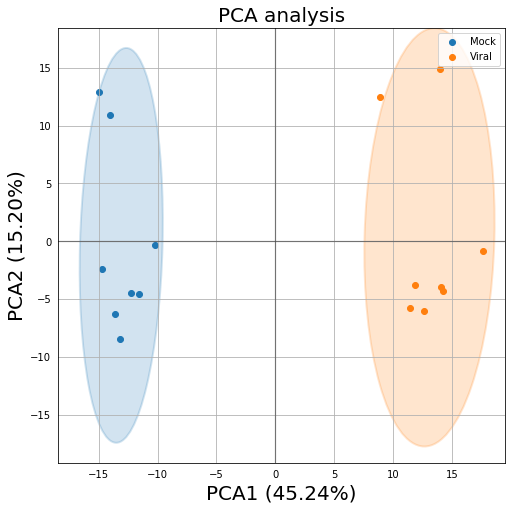

In [30]:
ax = pca.plot_row_coordinates(
    x1,
    ax=None,
    figsize=(8, 8),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=y1,
    ellipse_outline=True,
    ellipse_fill=True,
    show_points=True
)

inertia = pca.explained_inertia_
x_label = 'PCA{} ({:.2f}%)'.format(1, 100 * inertia[0])
y_label = 'PCA{} ({:.2f}%)'.format(2, 100 * inertia[1])
ax.set_title('PCA analysis', fontsize=20)
ax.set_xlabel(x_label, fontsize=20)
ax.set_ylabel(y_label, fontsize=20)
#ax.get_figure().savefig('2019_01_14_LCMS_MIAPACA2_KRASi_FGFRi_120h_no_label_automate_peak_picking_pos_PCA_plot.png')

There is a biologically significant difference in both conditions (Mock vs Viral) as both are separating from each other across PC1 (where PC1 explains ~45.24% variance of the data).

## Calculate Differential Expression (Using R Kernal)
The differential expression is calculated between the two conditions (here “Mock” and “Viral”). In general terms, it means calculating the log fold change and p val between the two conditions for each element (here metabolite). For calculation it uses the limma algorithm.

In [1]:
library(cmapR)
library(limma)
library(data.table)
pooltotal_gct_intensity  <- parse.gctx("labeled_LCMS_pooltotals.gct")
pooltotal_mode_gct_mat  <- as.data.frame(pooltotal_gct_intensity@mat)
pooltotal_mode_gct_rdesc  <- pooltotal_gct_intensity@rdesc
pooltotal_mode_gct_cdesc  <- pooltotal_gct_intensity@cdesc
condition <- pooltotal_mode_gct_cdesc$Cohort
design <- model.matrix(~ condition + 0)
colnames(design) <- c("Mock", "Viral")
contrast.matrix <- makeContrasts(Mock - Viral, levels = design)
pooltotal_matrix = as.matrix(log2(pooltotal_mode_gct_mat))
fit <- lmFit(pooltotal_matrix, design)
fit <- contrasts.fit(fit, contrast.matrix)
fit <- eBayes(fit)
tt <- topTable(fit, coef = "Mock - Viral", number = nrow(pooltotal_matrix))
total <- merge(pooltotal_mode_gct_rdesc, tt, by=0, all=TRUE)
print (head(total))
write.csv(total, "Labeled_LCMS_Mock_Viral_limma_results.csv", row.names=FALSE)

parsing as GCT v1.3
labeled_LCMS_pooltotals.gct 387 rows, 16 cols, 4 row descriptors, 1 col descriptors


                      Row.names              compound compoundId   medMz  medRt
1     1_C00022_87.009_8.588_neg              Pyruvate     C00022  87.009  8.588
2     10_C00133_88.04_8.075_neg             D-Alanine     C00133  88.040  8.075
3 100_C00637_158.061_16.022_neg Indole-3-acetaldehyde     C00637 158.061 16.022
4 101_C00637_158.061_15.427_neg Indole-3-acetaldehyde     C00637 158.061 15.427
5 102_C02656_159.066_14.201_neg              Pimelate     C02656 159.066 14.201
6  103_C00398_159.093_7.796_neg            Tryptamine     C00398 159.093  7.796
                             id      logFC  AveExpr           t      P.Value
1     1_C00022_87.009_8.588_neg  0.2716901 20.38475   0.5621342 5.821232e-01
2     10_C00133_88.04_8.075_neg -2.3991346 19.06679 -28.4210290 1.023172e-14
3 100_C00637_158.061_16.022_neg  0.5023706 15.56878   2.5323068 2.266595e-02
4 101_C00637_158.061_15.427_neg  1.3058922 14.22423   4.2195847 7.053839e-04
5 102_C02656_159.066_14.201_neg  0.1373606 15.55687   2

## Create CombiT Input
The COMBi-T algorithm is a network based strategy that integrating both transcriptomic and metaboloic profiling and differential regulation data are mapped onto the global network that includes both enzymes and metabolites. The global network is constructed based on the latest edition of the KEGG database. The weights are differential intensity p values assigned to the nodes(metabolites and enzymes) in the global network. Integrated network analysis then identifies the most coordinately responsive subnetwork and uncovers novel points of metabolic rewiring.

CombiT is performed between two conditions (here “Mock” and “Viral”) at a time. It takes the output of differential expression which should contain logFC and Pvalue columns for each ID (metabolite or gene). Generally, combiT runs on two different omics datasets (metabolics with transcriptomics or proteomics etc.) but it also works with single omics dataset (metabolics or transcriptomics).

↕

In [31]:
limma_results_df = pd.read_csv("Labeled_LCMS_Mock_Viral_limma_results.csv")
limma_results_df.head()

Row.names               compound compoundId    medMz  \
0      1_C00022_87.009_8.588_neg               Pyruvate     C00022   87.009   
1      10_C00133_88.04_8.075_neg              D-Alanine     C00133   88.040   
2  100_C00637_158.061_16.022_neg  Indole-3-acetaldehyde     C00637  158.061   
3  101_C00637_158.061_15.427_neg  Indole-3-acetaldehyde     C00637  158.061   
4  102_C02656_159.066_14.201_neg               Pimelate     C02656  159.066   

    medRt                             id     logFC    AveExpr          t  \
0   8.588      1_C00022_87.009_8.588_neg  0.271690  20.384754   0.562134   
1   8.075      10_C00133_88.04_8.075_neg -2.399135  19.066795 -28.421029   
2  16.022  100_C00637_158.061_16.022_neg  0.502371  15.568777   2.532307   
3  15.427  101_C00637_158.061_15.427_neg  1.305892  14.224229   4.219585   
4  14.201  102_C02656_159.066_14.201_neg  0.137361  15.556866   2.699378   

        P.Value     adj.P.Val          B  
0  5.821232e-01  6.587183e-01  -7.823880  
1  1.023172e-14  3.299729e-13  24.142552  
2  2.266595e-02  4.005353e-02  -5.139791  
3  7.053839e-04  1.819890e-03  -1.702163  
4  1.620344e-02  2.903117e-02  -4.818223

In [32]:
combit_input_df = filter_unique_cmpd_combiT(limma_results_df)
combit_input_df.head()

/home/rstudio/.local/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



ID     logFC       P.Value
uniqueId                                                     
1_C00022_87.009_8.588_neg      C00022  0.271690  5.821232e-01
10_C00133_88.04_8.075_neg      C00133 -2.399135  1.023172e-14
101_C00637_158.061_15.427_neg  C00637  1.305892  7.053839e-04
102_C02656_159.066_14.201_neg  C02656  0.137361  1.620344e-02
103_C00398_159.093_7.796_neg   C00398  0.391484  2.315655e-06

In [33]:
combit_input_df.to_csv('Labeled_LCMS_Mock_Viral_combit_input.csv', index=False)

## MESA Analysis
MSEA offers three different enrichment analyses for metabolomic studies i.e.
* Overrepresentation analysis (ORA)
* Single sample profiling (SSP)
* Quantitative enrichment analysis (QEA)

ORA requires only a list of compound names, while SSP and QEA require both compound names and compound concentrations.

This document will explain how to perform ORA and QEA in detail.


### Create ORA Input Format
A list of significant compounds is needed to perform ORA. All the metabolites whose pval is lesser than 0.05 are considered as significant.

In [34]:
# Filter compounds whose pval is less than 0.05
compoundId_sign_list = combit_input_df[combit_input_df['P.Value'] <= 0.05]['ID'].unique().tolist()
print (compoundId_sign_list)

['C00133', 'C00637', 'C02656', 'C00398', 'C00956', 'C01077', 'C00009', 'C00745', 'C05947', 'C00079', 'C01606', 'C00545', 'C16358', 'C16357', 'C16353', 'C19872', 'C00250', 'C00506', 'C01250', 'C00417', 'C00334', 'C05422', 'C01042', 'C15996', 'C05583', 'C05582', 'C01005', 'C00197', 'C01026', 'C00631', 'C01092', 'C00624', 'C00311', 'C00679', 'C01205', 'C00158', 'C00800', 'C00817', 'C00257', 'C00880', 'C00514', 'C15930', 'C16356', 'C02356', 'C00355', 'C12248', 'C00078', 'C02305', 'C11437', 'C00864', 'C00643', 'C01068', 'C00475', 'C00669', 'C04874', 'C03150', 'C03912', 'C16186', '14237477', 'HMDB0000982', '150971', '29927033', 'HMDB0004813', 'N-5-methyl-Urd', 'C00085', 'C00122', 'C01172', 'C00103', 'C00092', 'C01094', 'C00446', 'C00636', 'C01097', 'C00275', 'C15926', 'C03546', 'C00441', 'C04006', 'C01113', 'C06019', 'C00463', 'C05345', 'C00668', 'C00042', 'C06311', 'C00294', 'C01595', '73318', 'C00387', 'C00180', 'C03492', 'C00319', 'C02934', 'C04501', 'C04257', 'C00357', 'C00051', 'HMDB000

In [35]:
with open('Labeled_LCMS_Mock_Viral_MSEA_ORA_input.txt', 'w') as f:
    for compoundId in compoundId_sign_list:
        f.write("%s\n" % compoundId)

Steps to perform ORA are descibed in the Labeled_LCMS_Mock_Viral_MSEA_ORA_Metaboanalyst_Demo presentation.

<img src="ora_1_dpi72.png">

### Create QEA Input Format
Intensity data is needed to perform QEA. The intensity data contains duplicates of compound names (because of different peaks groups) which should be removed before running QEA. The duplicates are removed by pval (i.e. pval with lower value will be selected). The duplicates are already removed in the CombiT step

In [36]:
# Get list of unique Id's
unique_id_list = combit_input_df.index.values.tolist()
print (len(unique_id_list))

242


In [37]:
# filter unique ids
filtered_raw_intensity_df = pooltotal_df[pooltotal_df['uniqueId'].isin(unique_id_list)]
filtered_raw_intensity_df.head(5)

uniqueId         compound compoundId   medMz  medRt  \
0  1_C00022_87.009_8.588_neg         Pyruvate     C00022  87.009  8.588   
1  2_C00222_87.009_8.588_neg  3-Oxopropanoate     C00222  87.009  8.588   
3   4_C00099_88.04_8.075_neg     beta-Alanine     C00099   88.04  8.075   
5   6_C00213_88.04_8.075_neg        Sarcosine     C00213   88.04  8.075   
7   8_C00041_88.04_8.075_neg        L-Alanine     C00041   88.04  8.075   

   091215_240M  091215_240i  091215_120M  091215_120i  091215_45M  ...  \
0   3727186.46   4071003.86   3098207.23   3284741.51  1395135.02  ...   
1   3727186.46   4071003.86   3098207.23   3284741.51  1395135.02  ...   
3    234399.52   1221191.74    256613.57   1266148.35   221301.78  ...   
5    234399.52   1221191.74    256613.57   1266148.35   221301.78  ...   
7    234399.52   1221191.74    256613.57   1266148.35   221301.78  ...   

   091215_15M  091215_15i  091215_5M   091215_5i  091215_3M   091215_3i  \
0  1097686.06   892763.62  936881.63   687294.65  930822.45   414662.61   
1  1097686.06   892763.62  936881.63   687294.65  930822.45   414662.61   
3   227213.71   999851.47  233692.97  1317514.13  228053.86  1292719.46   
5   227213.71   999851.47  233692.97  1317514.13  228053.86  1292719.46   
7   227213.71   999851.47  233692.97  1317514.13  228053.86  1292719.46   

    091215_1M   091215_1i   091215_0M   091215_0i  
0  1011162.69   601461.24  1681000.95  1997775.31  
1  1011162.69   601461.24  1681000.95  1997775.31  
3   219383.06  1210737.68   302015.26  1460792.82  
5   219383.06  1210737.68   302015.26  1460792.82  
7   219383.06  1210737.68   302015.26  1460792.82  

[5 rows x 21 columns]

In [38]:
# Samples in rows
id_cols = ['uniqueId', 'compound', 'medMz', 'medRt']
data_cols = filtered_raw_intensity_df.columns
drop_cols = set(id_cols) & set(data_cols)
id_to_samples_df = filtered_raw_intensity_df.drop(drop_cols, axis=1)
id_to_samples_df = id_to_samples_df.set_index('compoundId').T.astype(float)
id_to_samples_df = id_to_samples_df.reset_index().rename(columns = {'index':'SampleName'})
id_to_samples_df.head(5)

compoundId   SampleName      C00022      C00222      C00099      C00213  \
0           091215_240M  3727186.46  3727186.46   234399.52   234399.52   
1           091215_240i  4071003.86  4071003.86  1221191.74  1221191.74   
2           091215_120M  3098207.23  3098207.23   256613.57   256613.57   
3           091215_120i  3284741.51  3284741.51  1266148.35  1266148.35   
4            091215_45M  1395135.02  1395135.02   221301.78   221301.78   

compoundId      C00041      C00133      C00009     C01234       C00334  ...  \
0            234399.52   234399.52  1939681.12   80670.85  11714408.19  ...   
1           1221191.74  1221191.74  1329934.38   78784.84  12948311.94  ...   
2            256613.57   256613.57  2603041.00   89395.00   9856860.36  ...   
3           1266148.35  1266148.35  1615360.00   79206.26  13522536.16  ...   
4            221301.78   221301.78  3101752.50  105197.28  15112894.03  ...   

compoundId       C00096       C00043       C00203       C01170       C00127  \
0           16269324.72  16267681.73  16267681.73  16267681.73   2745554.92   
1            7222972.37   7324953.69   7324953.69   7324953.69  10971280.97   
2           20819458.89  20811537.13  20811537.13  20811537.13   3606557.31   
3            8200094.21   8218136.03   8218136.03   8218136.03  11159946.41   
4           16969460.36  16957326.70  16957326.70  16957326.70   2553531.84   

compoundId     C00128    C00003     C00004     C00005    C00024  
0           122656.90  33924.83  233566.96  107778.65  19240.47  
1           267710.39  21526.70  370047.52     454.04  27412.99  
2           202289.17  40893.94  238701.99  133914.44  20497.14  
3           345023.64  24729.40  364161.01    3320.20  34777.33  
4           233044.27  45451.46  698159.50  219480.93  33402.72  

[5 rows x 243 columns]

In [39]:
# Create metaboanalyst for "Mutant_proto" to "WT_proto" comparison
cohorts = ['Mock', 'Viral']
samples_list = id_to_samples_df.columns.tolist()[1:]
columns_order = ['SampleName', 'Cohort'] + samples_list
id_to_samples_cohorts_df =id_to_samples_df.merge(metadata_df, on="SampleName", how = 'inner')
id_to_samples_cohorts_df = id_to_samples_cohorts_df[columns_order]
binary_cohorts_id_samples_df = id_to_samples_cohorts_df[id_to_samples_cohorts_df['Cohort'].isin(cohorts)]
binary_cohorts_id_samples_df = binary_cohorts_id_samples_df.sort_values(['Cohort'])
binary_cohorts_id_samples_df.to_csv('Labeled_LCMS_Mock_Viral_MSEA_QEA_input.csv',index=False)
binary_cohorts_id_samples_df.head()

SampleName Cohort      C00022      C00222     C00099     C00213  \
0  091215_240M   Mock  3727186.46  3727186.46  234399.52  234399.52   
2  091215_120M   Mock  3098207.23  3098207.23  256613.57  256613.57   
4   091215_45M   Mock  1395135.02  1395135.02  221301.78  221301.78   
6   091215_15M   Mock  1097686.06  1097686.06  227213.71  227213.71   
8    091215_5M   Mock   936881.63   936881.63  233692.97  233692.97   

      C00041     C00133      C00009     C01234  ...       C00096       C00043  \
0  234399.52  234399.52  1939681.12   80670.85  ...  16269324.72  16267681.73   
2  256613.57  256613.57  2603041.00   89395.00  ...  20819458.89  20811537.13   
4  221301.78  221301.78  3101752.50  105197.28  ...  16969460.36  16957326.70   
6  227213.71  227213.71  5071538.00  119665.84  ...  16710008.72  16690908.54   
8  233692.97  233692.97  4846612.50  113035.31  ...  17534902.10  17490976.90   

        C00203       C01170      C00127     C00128    C00003     C00004  \
0  16267681.73  16267681.73  2745554.92  122656.90  33924.83  233566.96   
2  20811537.13  20811537.13  3606557.31  202289.17  40893.94  238701.99   
4  16957326.70  16957326.70  2553531.84  233044.27  45451.46  698159.50   
6  16690908.54  16690908.54  2409003.16  245756.59  41068.10  666069.60   
8  17490976.90  17490976.90  2261359.19  226326.76  46138.19  781438.01   

      C00005    C00024  
0  107778.65  19240.47  
2  133914.44  20497.14  
4  219480.93  33402.72  
6  371880.96  30318.97  
8  334723.66  28840.53  

[5 rows x 244 columns]

Steps to perform QEA are descibed in the Labeled_LCMS_Mock_Viral_MSEA_QEA_Metaboanalyst_Demo presentation.
<img src="qea_0_dpi72.png">
<img src="norm_0_dpi72.png">
<img src="snorm_0_dpi72.png">
